In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime
import glob
import os
import Ngl
import matplotlib.pyplot as plt
import matplotlib.patches as patches


import warnings
warnings.filterwarnings('ignore')


In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    
    return ds


In [3]:
def interpolateToPressure_v2(DS, varName, pressGoals):
    p0mb = DS.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DS.hyam.values)[:]
    hybm = np.squeeze(DS.hybm.values)[:]
    hyai = np.squeeze(DS.hyai.values)[:]
    hybi = np.squeeze(DS.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

In [4]:
def preprocess_h0(ds):
        
    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
    
    # Compute local time 
    localTimes = ds['time'].values - np.timedelta64(5,'h')
    ds         = ds.assign_coords({"time": localTimes})    
    
    
    ## Interpolate to pressure levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,15.0) 

    ds = ds.assign_coords({"levInterp": pnew64})

    varSels = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WPRTP_CLUBB','WPTHLP_CLUBB','WP3_CLUBB','WP2_CLUBB','UP2_CLUBB',
                          'VP2_CLUBB','Z3','U','V','T','Q','OMEGA','RVMTEND_CLUBB','STEND_CLUBB','CLDLIQ','CLOUD','CLOUDFRAC_CLUBB',
                          'UPWP_CLUBB','THETAL','CONCLD',
                           ])

    for iVar in range(len(varSels)): 
        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2(ds, varSels[iVar], pnew64)

        ds[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)

    
    ## Resample to 60-minutes 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    dsSel = ds.load().resample(time="60Min", keep_attrs=True).mean()
    print('NOTE: output being resampled to hourly')
    
    
        
    return dsSel

# Pre-processing to get CLM data
def preprocessCLM_h0(ds):
    
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
    
    # Compute local time 
    localTimes = ds['time'].values - np.timedelta64(5,'h')
    ds         = ds.assign_coords({"time": localTimes})
    
    dsSel = ds.load().resample(time="60Min", keep_attrs=True).mean()
    
    return dsSel



## Read in data

In [5]:
stagingDir  = '/glade/u/home/mdfowler/temp/'

caseStrings = ['FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataFALSE_setSfcFlx.001', 
               'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_setSfcFlx.001',
               'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataFALSE_setSfcFlxFALSE.002', 
               'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_setSfcFlxFALSE.002'] 

case_names  = ['ctrl_MF', 'clasp_MF','ctrl_MF_noflxset','clasp_MF_noflxset']

for iCase in range(len(case_names)):
    print('*** Starting on case %s ***' % (case_names[iCase]))

    # - - - - - - - - - - - - - -     
    ## Get list of files 
    # - - - - - - - - - - - - - - 
    listFiles_h0    = np.sort(glob.glob(stagingDir+caseStrings[iCase]+'/atm/hist/'+caseStrings[iCase]+'*cam.h0*'))
    listFilesCLM_h0 = np.sort(glob.glob(stagingDir+caseStrings[iCase]+'/lnd/hist/'+caseStrings[iCase]+'*clm2.h0*'))

    case_h0 = xr.open_mfdataset(listFiles_h0, preprocess=preprocess_h0, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h0 files loaded with mfdataset')
    
    namesDS = xr.open_dataset(listFiles_h0[0], decode_times=False)
            
    ## Combine all the cases into 
    case_allDays      = case_h0.assign_coords({"case":  case_names[iCase]})
    
    if iCase==0:
        scamDS   = case_allDays
    else: 
        scamDS   = xr.concat([scamDS, case_allDays], "case") 
        
        
    # - - - - - - - - - - - - - -         
    # Read in CLM datasets too 
    # - - - - - - - - - - - - - - 
    caseCLM_h0 = xr.open_mfdataset(listFilesCLM_h0, preprocess=preprocessCLM_h0, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal')
    print('CLM_h0 files loaded with mfdataset')
        
    caseCLMh0_allDays = caseCLM_h0.assign_coords({"case":  case_names[iCase]})
        
    if iCase==0:
        clmDS_h0 = caseCLMh0_allDays
    else: 
        clmDS_h0 = xr.concat([clmDS_h0, caseCLMh0_allDays], "case") 
            
    print('Done with case %i of %i ' % (iCase+1, len(case_names)))



*** Starting on case ctrl_MF ***
Beginning interpolation...
NOTE: output being resampled to hourly
h0 files loaded with mfdataset
CLM_h0 files loaded with mfdataset
Done with case 1 of 4 
*** Starting on case clasp_MF ***
Beginning interpolation...
NOTE: output being resampled to hourly
h0 files loaded with mfdataset
CLM_h0 files loaded with mfdataset
Done with case 2 of 4 
*** Starting on case ctrl_MF_noflxset ***
Beginning interpolation...
NOTE: output being resampled to hourly
h0 files loaded with mfdataset
CLM_h0 files loaded with mfdataset
Done with case 3 of 4 
*** Starting on case clasp_MF_noflxset ***
Beginning interpolation...
NOTE: output being resampled to hourly
h0 files loaded with mfdataset
CLM_h0 files loaded with mfdataset
Done with case 4 of 4 


In [6]:
CLMnamesDS = xr.open_dataset(listFilesCLM_h0[0], decode_times=False)

In [5]:
# iopFile = '/glade/p/cesmdata/cseg/inputdata/atm/cam/scam/iop/ARM97_4scam.nc'
# iopDS   = xr.open_dataset(iopFile, decode_times = False)

# for iT in range(len(iopDS.time.values)): 
#     thisTime = datetime.datetime(iopDS.year.values[iT],
#                       iopDS.month.values[iT],
#                       iopDS.day.values[iT],
#                       hour=iopDS.hour.values[iT])
#     if iT==0: 
#         dateArr = thisTime
#     else:
#         dateArr = np.append(dateArr, thisTime)

# # Compute local time 
# iopDS = iopDS.assign_coords({"time": pd.to_datetime(dateArr) })
# # iopDS['time'] = iopDS.indexes['time'].to_datetimeindex() 
# localTimes    = iopDS['time'].values - np.timedelta64(5,'h')
# iopDS         = iopDS.assign_coords({"time": localTimes})
    

## Make some plots

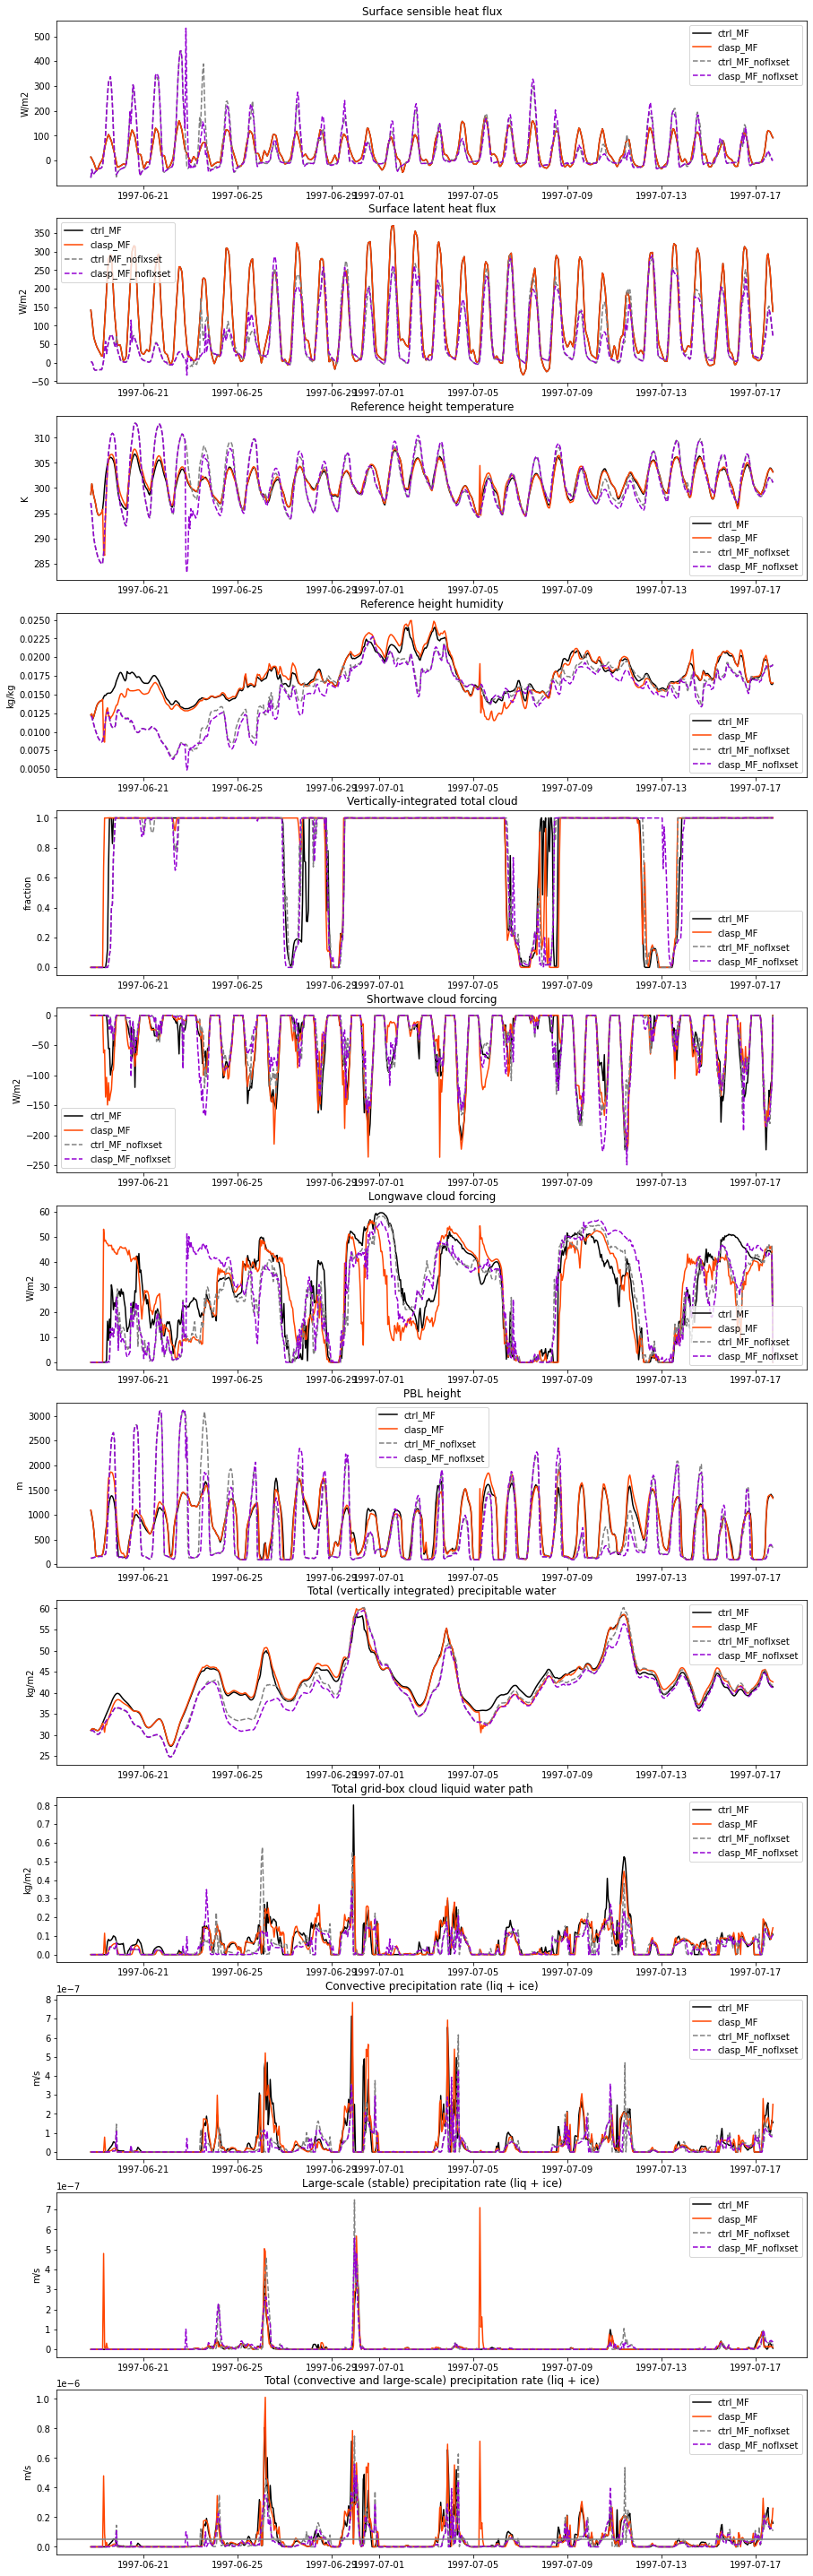

In [7]:

pltVars = ['SHFLX','LHFLX','TREFHT','QREFHT','CLDTOT','SWCF','LWCF','PBLH','TMQ','TGCLDLWP','PRECC','PRECL','PRECT']
lineSel = ['k', 'orangered', 'gray', 'darkviolet']
styleSel = ['-', '-', '--','--']

fig,axs = plt.subplots(len(pltVars),1, figsize=(15,4*len(pltVars)))
axs     = axs.ravel()

for iVar in range(len(pltVars)):
    for iCase in range(len(scamDS.case.values)): 
        axs[iVar].plot(scamDS.time.values, 
                    np.squeeze(scamDS[pltVars[iVar]].sel(case=scamDS.case.values[iCase]).values), 
                    color = lineSel[iCase], linestyle=styleSel[iCase], 
                    label=scamDS.case.values[iCase])
    # Add shading for rain event? 
    # axs[iVar].fill_between(scamDS.time.values, 0, 1, where=np.squeeze(scamDS.sel(case='ctrl_MF')['PRECT'].values) > 0.1e-6,
    #             color='blue', alpha=0.2, transform=axs[iVar].get_xaxis_transform())
             
    
    axs[iVar].legend()
    axs[iVar].set_title(namesDS[pltVars[iVar]].long_name)
    axs[iVar].set_ylabel(namesDS[pltVars[iVar]].units)
    # axs[iVar].set_xlim([scamDS.time.values[24],
    #                     scamDS.time.values[24*8]])
    
# axs[0].set_ylim([295,309])
# axs[1].set_ylim([0.01,0.02])

axs[len(pltVars)-1].axhline(0.05e-6, color='grey')
    

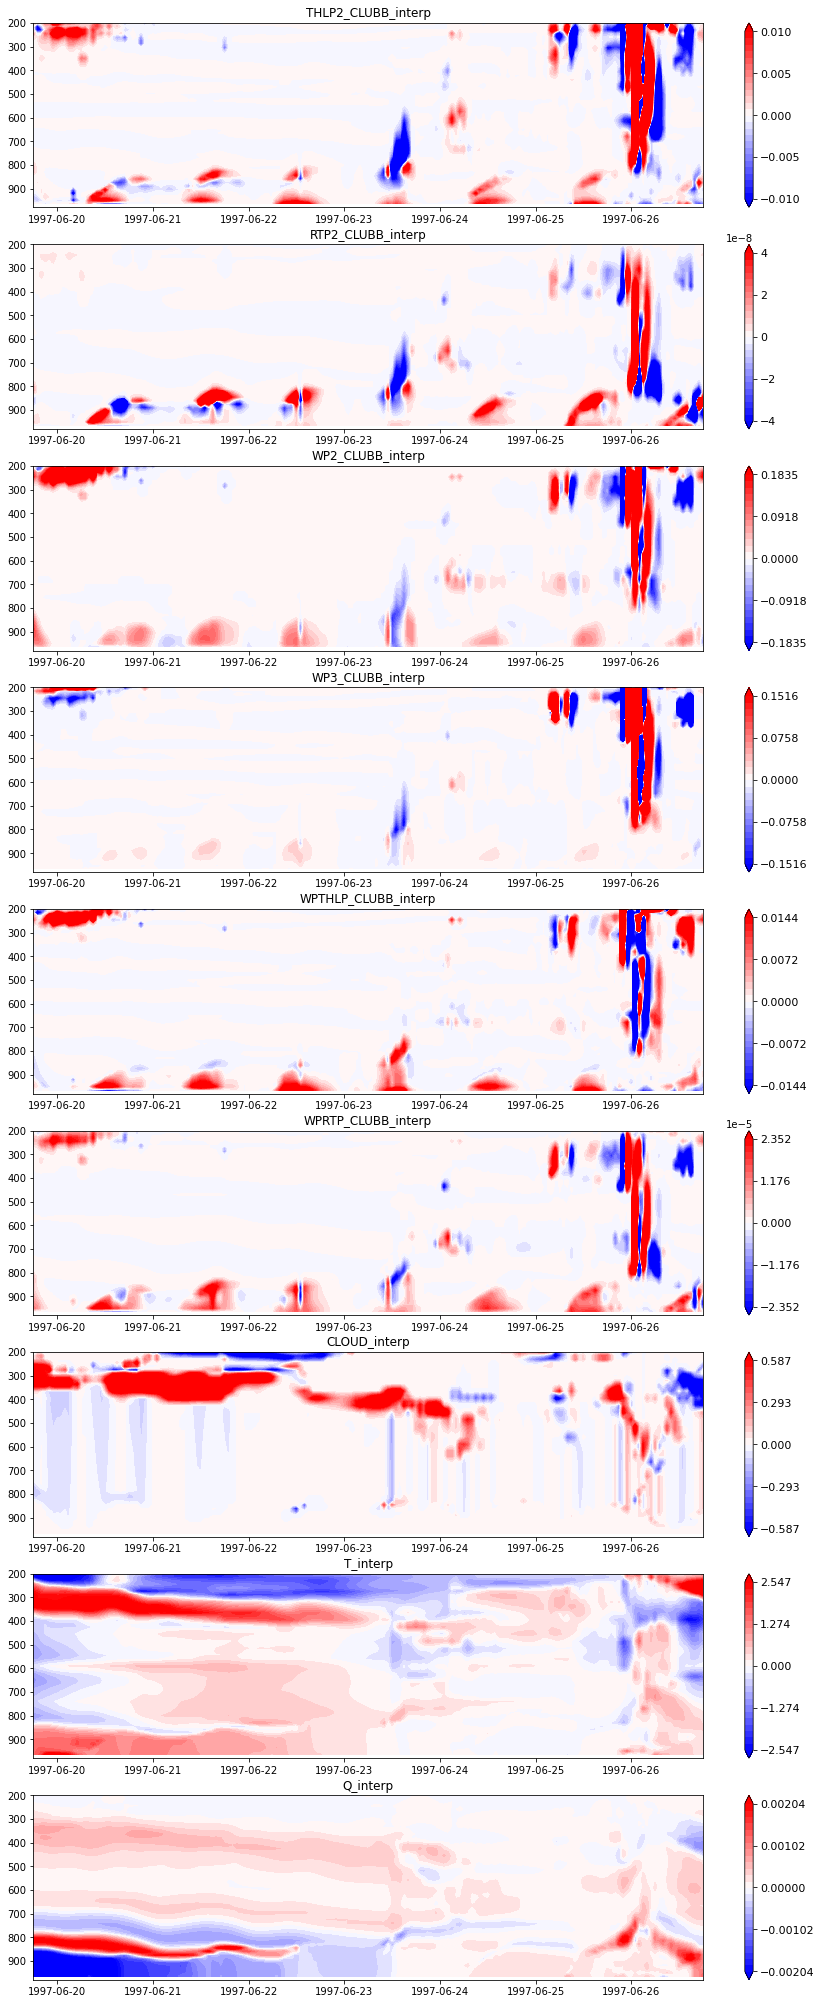

In [86]:

pltVars = ['THLP2_CLUBB_interp','RTP2_CLUBB_interp',
           'WP2_CLUBB_interp','WP3_CLUBB_interp',
           'WPTHLP_CLUBB_interp','WPRTP_CLUBB_interp',
           'CLOUD_interp','T_interp','Q_interp']
# levName = ['ilev','ilev','ilev','ilev','ilev','ilev','lev','lev']

fig,axs = plt.subplots(len(pltVars),1, figsize=(15,4*len(pltVars)))
axs = axs.ravel()

for iVar in range(len(pltVars)):
    varDiff = scamDS[pltVars[iVar]].sel(case='clasp_MF')  - scamDS[pltVars[iVar]].sel(case='ctrl_MF') 
    
    if pltVars[iVar]=='RTP2_CLUBB_interp':
        varDiff = varDiff * 1e-6 # Convert to kg2/kg2
    
    diffHigh = np.nanpercentile(varDiff,98)
    diffLow  = np.nanpercentile(varDiff,2)
    clevMax  = np.nanmax([np.abs(diffHigh), np.abs(diffLow)])
    
    if pltVars[iVar]=='THLP2_CLUBB_interp':
        clevMax = 0.01
    elif pltVars[iVar]=='RTP2_CLUBB_interp':
        clevMax = 0.4e-7
    
    clevs    = np.arange(-clevMax, clevMax+((clevMax*2)/26), (clevMax*2)/26)

    
    cplt = axs[iVar].contourf(varDiff.time.values, 
                              varDiff['levInterp'].values,
                              np.squeeze(varDiff).transpose(), 
                              clevs, 
                              cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[iVar],
                        ticks=[-clevMax, -clevMax/2, 0, clevMax/2, clevMax])
    cbar.ax.locator_params(nbins=6)
    # cbar.ax.set_title(namesDS[pltVars[iVar]].units, fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    axs[iVar].invert_yaxis()
    axs[iVar].set_ylim([980,200])
    axs[iVar].set_xlim([varDiff.time.values[24],
                        varDiff.time.values[24*8]])

    axs[iVar].set_title(pltVars[iVar])
    

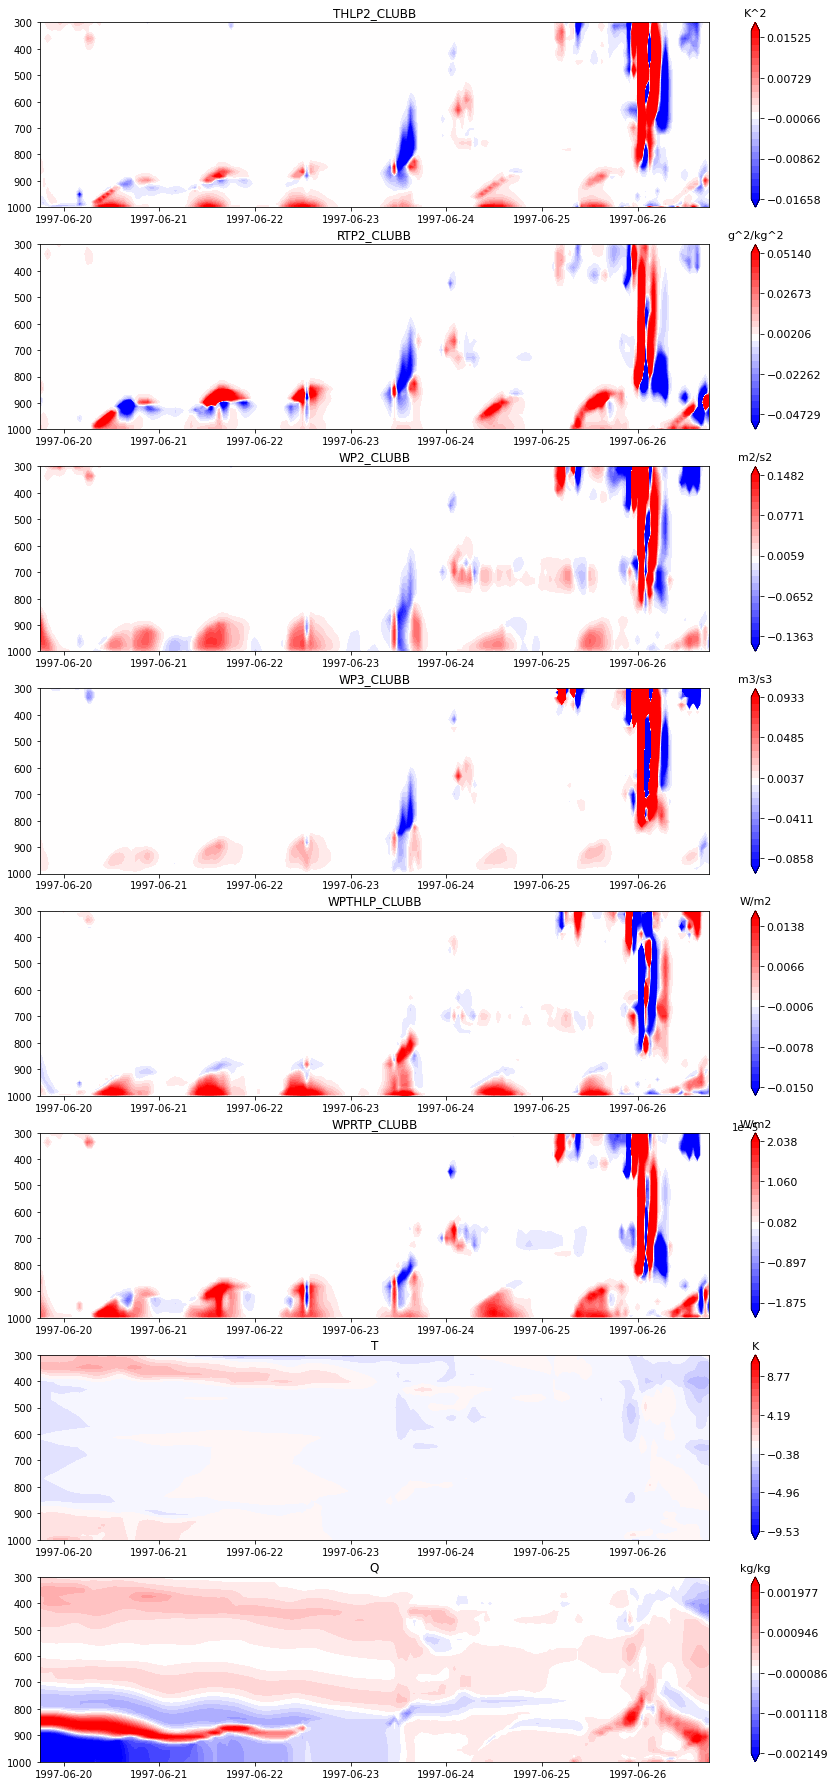

In [37]:

pltVars = ['THLP2_CLUBB','RTP2_CLUBB',
           'WP2_CLUBB','WP3_CLUBB',
           'WPTHLP_CLUBB','WPRTP_CLUBB',
           'T','Q']
levName = ['ilev','ilev','ilev','ilev','ilev','ilev','lev','lev']

fig,axs = plt.subplots(len(pltVars),1, figsize=(15,4*len(pltVars)))
axs = axs.ravel()

for iVar in range(len(pltVars)):
    varDiff = scamDS[pltVars[iVar]].sel(case='clasp_MF')  - scamDS[pltVars[iVar]].sel(case='ctrl_MF') 
        
    diffHigh = np.nanpercentile(varDiff,98)
    diffLow  = np.nanpercentile(varDiff,2)
    clevMax  = np.nanmax([np.abs(diffHigh), np.abs(diffLow)])
    clevs    = np.arange(-clevMax, clevMax+((clevMax*2)/25), (clevMax*2)/25)

    cplt = axs[iVar].contourf(varDiff.time.values, 
                              varDiff[levName[iVar]].values,
                              np.squeeze(varDiff).transpose(), 
                              clevs, 
                              cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[iVar])
    cbar.ax.locator_params(nbins=5)
    cbar.ax.set_title(namesDS[pltVars[iVar]].units, fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    axs[iVar].invert_yaxis()
    axs[iVar].set_ylim([1000,300])
    axs[iVar].set_xlim([varDiff.time.values[24],
                        varDiff.time.values[24*8]])

    axs[iVar].set_title(pltVars[iVar])
    

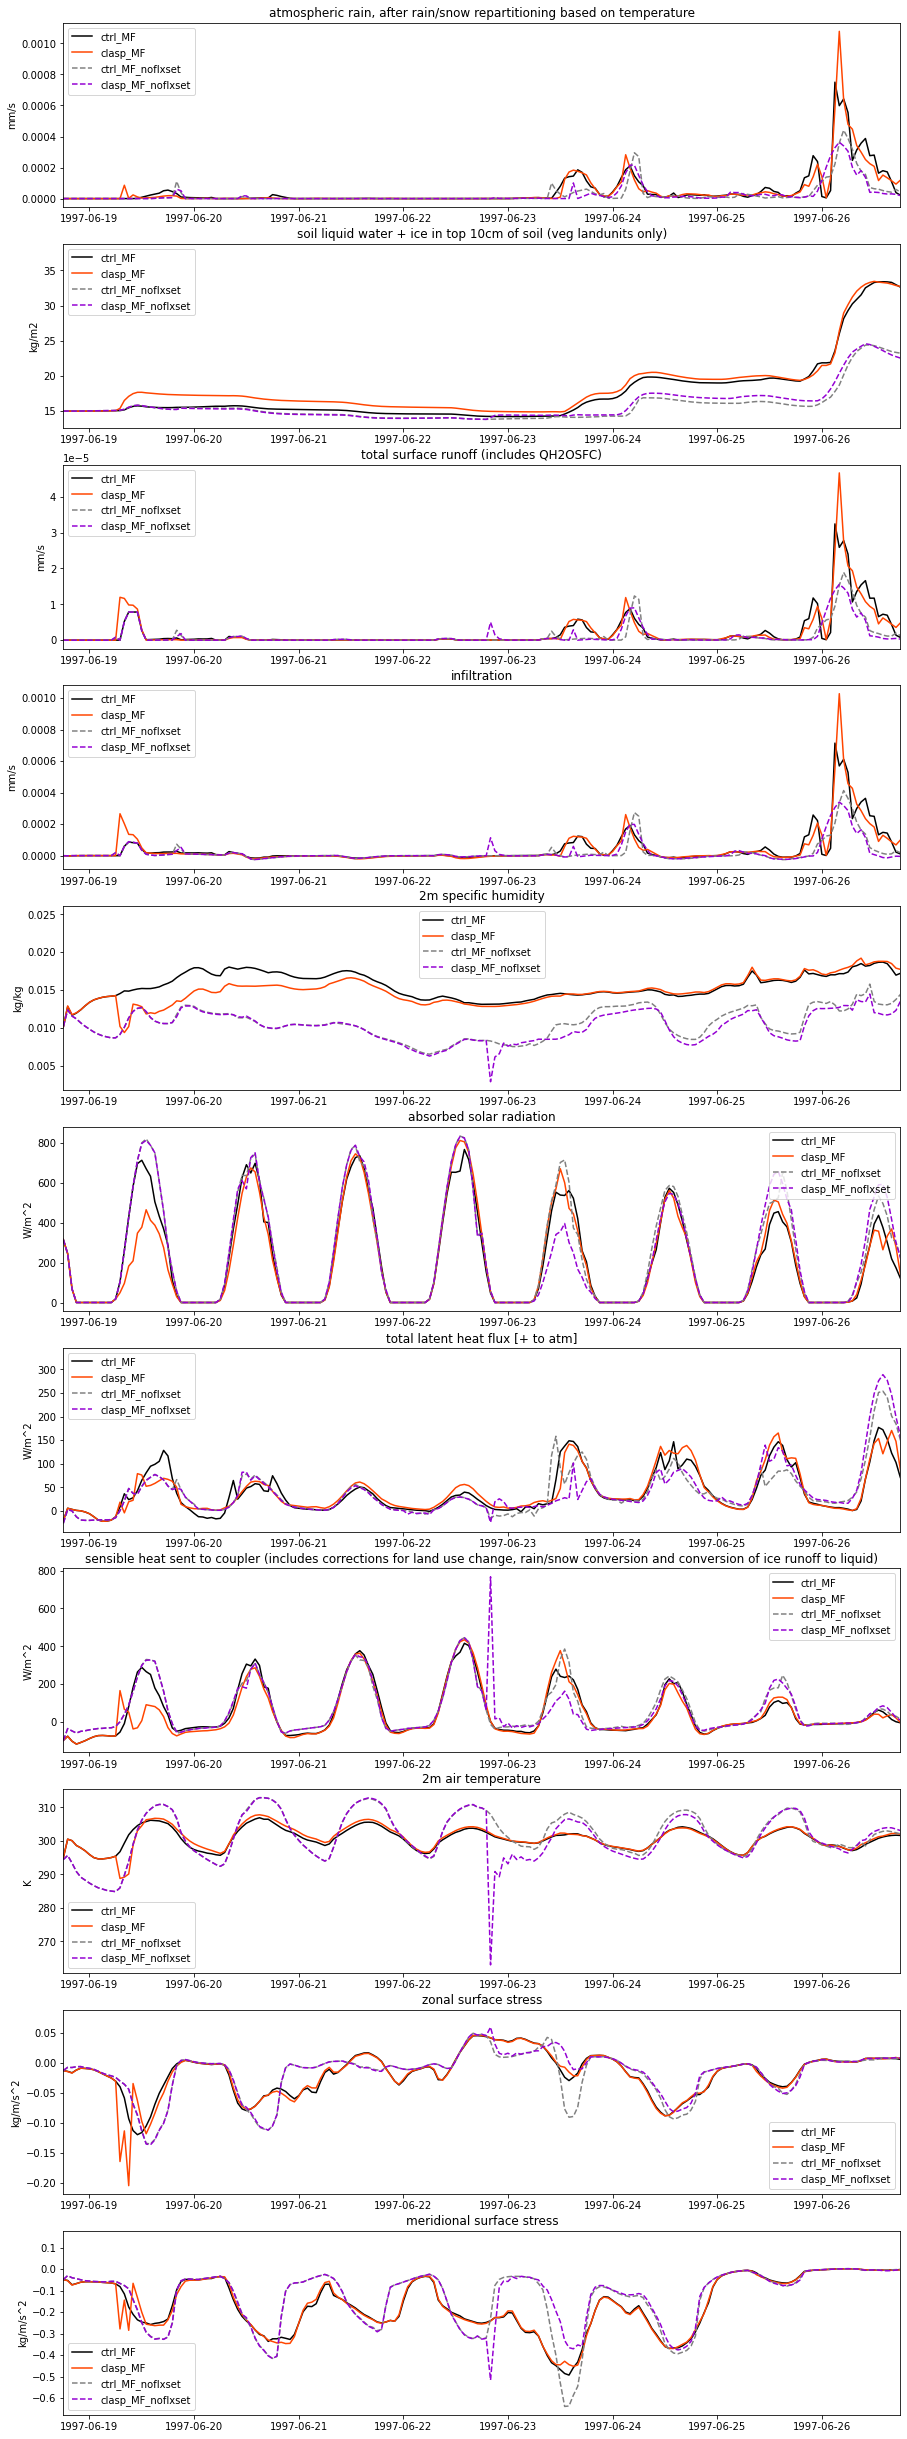

In [138]:

pltVars = ['RAIN','SOILWATER_10CM','QOVER','QINFL','Q2M','FSA','EFLX_LH_TOT','FSH_TO_COUPLER','TSA','TAUX','TAUY']
lineSel = ['k', 'orangered', 'gray', 'darkviolet']
styleSel = ['-', '-', '--','--']

fig,axs = plt.subplots(len(pltVars),1, figsize=(15,4*len(pltVars)))
axs     = axs.ravel()

for iVar in range(len(pltVars)):
    for iCase in range(len(clmDS_h0.case.values)): 
        axs[iVar].plot(clmDS_h0.time.values, 
                    np.squeeze(clmDS_h0[pltVars[iVar]].sel(case=clmDS_h0.case.values[iCase]).values), 
                    color = lineSel[iCase], linestyle=styleSel[iCase], 
                    label=clmDS_h0.case.values[iCase])
    # Add shading for rain event? 
    # axs[iVar].fill_between(scamDS.time.values, 0, 1, where=np.squeeze(scamDS.sel(case='ctrl_MF')['PRECT'].values) > 0.1e-6,
    #             color='blue', alpha=0.2, transform=axs[iVar].get_xaxis_transform())
             
    
    axs[iVar].legend()
    axs[iVar].set_title(CLMnamesDS[pltVars[iVar]].long_name)
    axs[iVar].set_ylabel(CLMnamesDS[pltVars[iVar]].units)
    axs[iVar].set_xlim([scamDS.time.values[0],
                        scamDS.time.values[24*8]])
    
# axs[0].set_ylim([295,309])
# axs[1].set_ylim([0.01,0.02])

# axs[len(pltVars)-1].axhline(0.05e-6, color='grey')
    

In [128]:
CLMnamesDS

<xarray.Dataset>
Dimensions:                        (cft: 2, glc_nec: 10, hist_interval: 2, levdcmp: 1, levgrnd: 25, levlak: 10, levsoi: 20, lndgrid: 1, ltype: 9, natpft: 15, nvegwcs: 4, time: 2089)
Coordinates:
  * levgrnd                        (levgrnd) float32 0.01 0.04 ... 28.87 42.0
  * levsoi                         (levsoi) float32 0.01 0.04 0.09 ... 6.94 8.03
  * levlak                         (levlak) float32 0.05 0.6 2.1 ... 34.33 44.78
  * levdcmp                        (levdcmp) float32 1.0
  * time                           (time) float32 0.0 0.01389 ... 28.99 29.0
Dimensions without coordinates: cft, glc_nec, hist_interval, lndgrid, ltype, natpft, nvegwcs
Data variables:
    mcdate                         (time) int32 ...
    mcsec                          (time) int32 ...
    mdcur                          (time) int32 ...
    mscur                          (time) int32 ...
    nstep                          (time) int32 ...
    time_bounds                    (time, hist_interval) float64 ...
    date_written                   (time) |S16 ...
    time_written                   (time) |S16 ...
    lon                            (lndgrid) float32 ...
    lat                            (lndgrid) float32 ...
    area                           (lndgrid) float32 ...
    landfrac                       (lndgrid) float32 ...
    landmask                       (lndgrid) float64 ...
    pftmask                        (lndgrid) float64 ...
    nbedrock                       (lndgrid) float64 ...
    ZSOI                           (levgrnd, lndgrid) float32 ...
    DZSOI                          (levgrnd, lndgrid) float32 ...
    WATSAT                         (levgrnd, lndgrid) float32 ...
    SUCSAT                         (levgrnd, lndgrid) float32 ...
    BSW                            (levgrnd, lndgrid) float32 ...
    HKSAT                          (levgrnd, lndgrid) float32 ...
    ZLAKE                          (levlak, lndgrid) float32 ...
    DZLAKE                         (levlak, lndgrid) float32 ...
    PCT_SAND                       (levsoi, lndgrid) float32 ...
    PCT_CLAY                       (levsoi, lndgrid) float32 ...
    ATM_TOPO                       (time, lndgrid) float32 ...
    BCDEP                          (time, lndgrid) float32 ...
    BTRANMN                        (time, lndgrid) float32 ...
    DSL                            (time, lndgrid) float32 ...
    DSTDEP                         (time, lndgrid) float32 ...
    DSTFLXT                        (time, lndgrid) float32 ...
    EFLXBUILD                      (time, lndgrid) float32 ...
    EFLX_DYNBAL                    (time, lndgrid) float32 ...
    EFLX_GRND_LAKE                 (time, lndgrid) float32 ...
    EFLX_LH_TOT                    (time, lndgrid) float32 ...
    EFLX_LH_TOT_R                  (time, lndgrid) float32 ...
    ELAI                           (time, lndgrid) float32 ...
    ERRH2O                         (time, lndgrid) float32 ...
    ERRH2OSNO                      (time, lndgrid) float32 ...
    ERRSEB                         (time, lndgrid) float32 ...
    ERRSOI                         (time, lndgrid) float32 ...
    ERRSOL                         (time, lndgrid) float32 ...
    ESAI                           (time, lndgrid) float32 ...
    FCEV                           (time, lndgrid) float32 ...
    FCOV                           (time, lndgrid) float32 ...
    FCTR                           (time, lndgrid) float32 ...
    FGEV                           (time, lndgrid) float32 ...
    FGR                            (time, lndgrid) float32 ...
    FGR12                          (time, lndgrid) float32 ...
    FH2OSFC                        (time, lndgrid) float32 ...
    FIRA                           (time, lndgrid) float32 ...
    FIRA_R                         (time, lndgrid) float32 ...
    FIRE                           (time, lndgrid) float32 ...
    FIRE_R                         (time, lndgrid) floa

In [9]:
## Drop the first day just in case? 
print(scamDS.time.values[0])
print(scamDS.time.values[24])


1997-06-18T18:00:00.000000000
1997-06-19T18:00:00.000000000


In [14]:
hourlyMeanSCAM  = scamDS.isel(time=np.arange(24,len(scamDS.time.values))).groupby('time.hour').mean(dim='time')
# hourlyMeanIOP   = iopDS.groupby('time.hour').mean(dim='time')


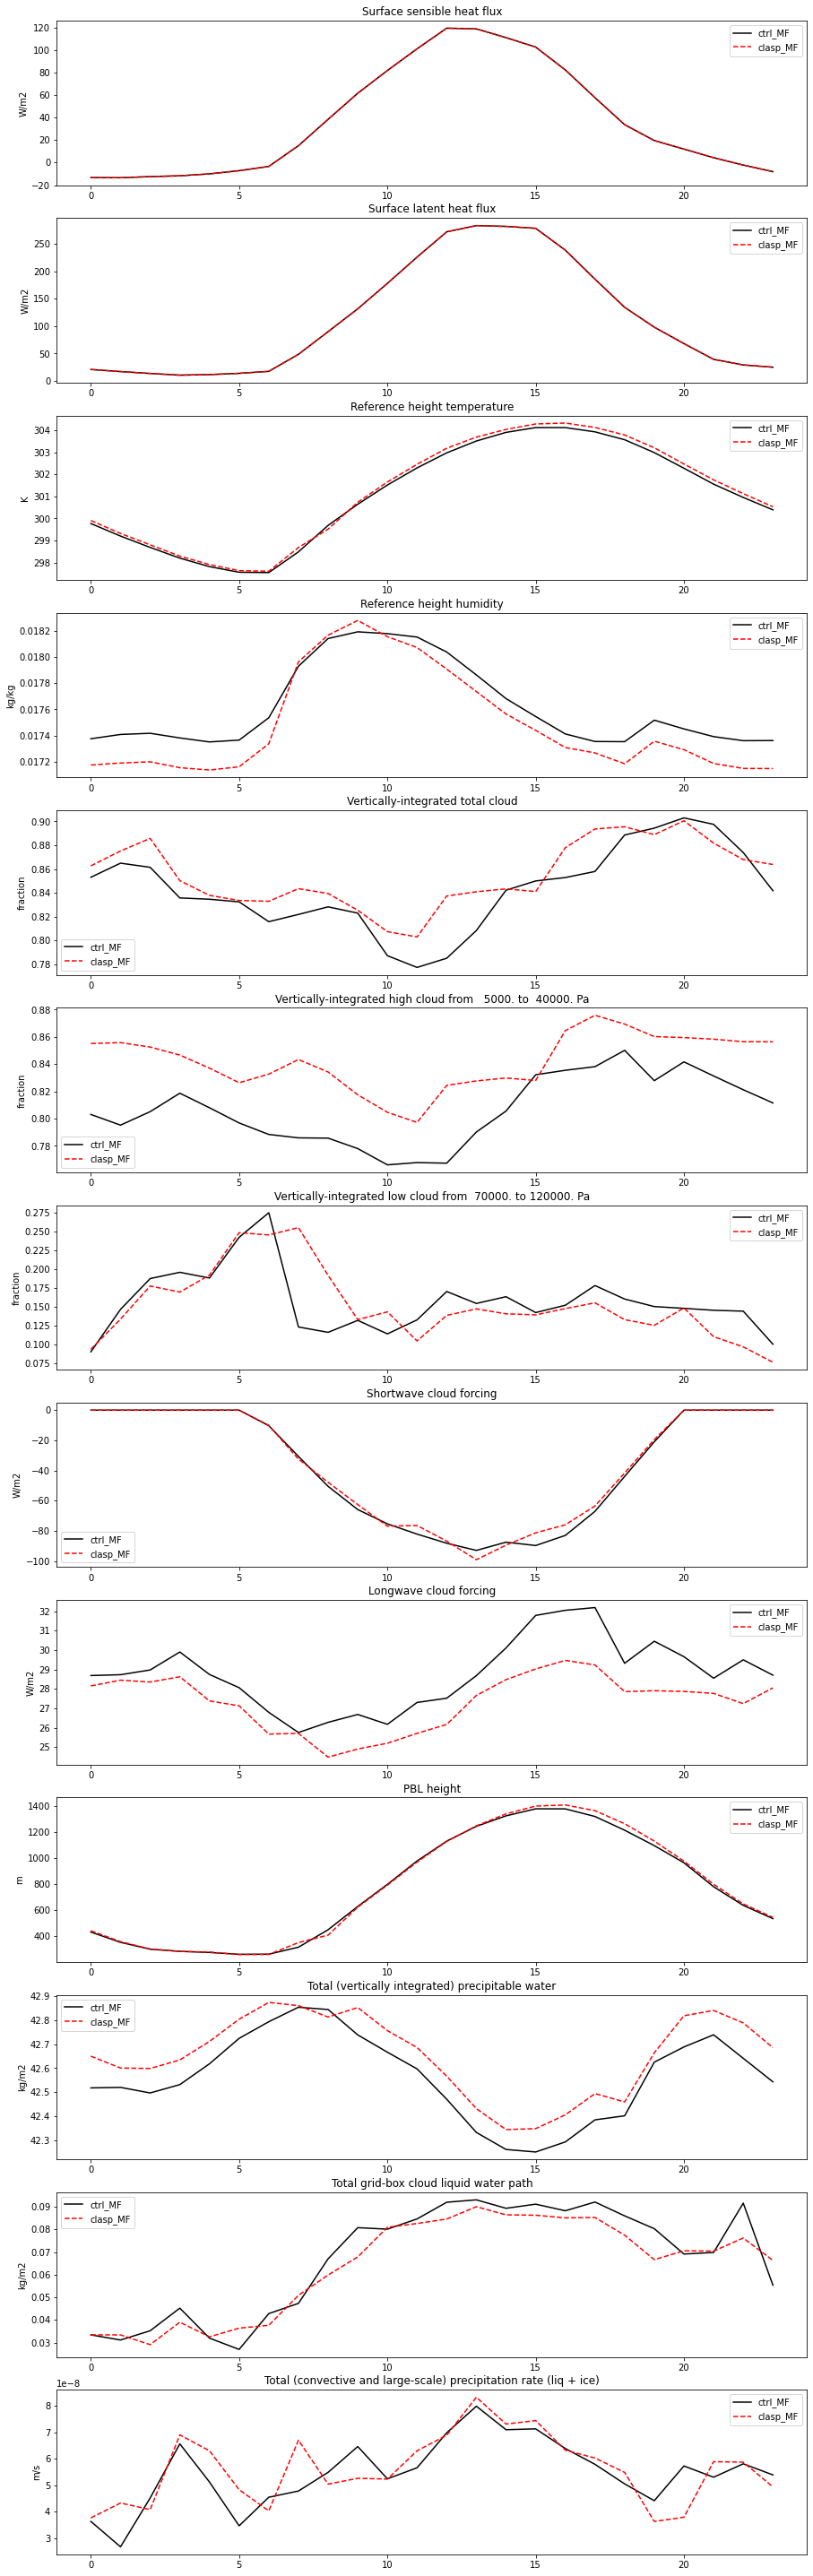

In [18]:

pltVars = ['SHFLX','LHFLX', 'TREFHT', 'QREFHT',
           'CLDTOT','CLDHGH','CLDLOW','SWCF','LWCF',
           'PBLH','TMQ','TGCLDLWP','PRECT']
lineSel = ['k','r--']

fig,axs = plt.subplots(len(pltVars),1, figsize=(15,4*len(pltVars)))
axs = axs.ravel()

# for iVar in range(len(pltVars)):
for iVar in range(len(pltVars)):
    for iCase in range(2): 
        axs[iVar].plot(hourlyMeanSCAM.hour.values, 
                    np.squeeze(hourlyMeanSCAM[pltVars[iVar]].sel(case=hourlyMeanSCAM.case.values[iCase]).values), 
                    lineSel[iCase],
                    label=hourlyMeanSCAM.case.values[iCase])
        
    axs[iVar].legend()
    axs[iVar].set_title(namesDS[pltVars[iVar]].long_name)
    axs[iVar].set_ylabel(namesDS[pltVars[iVar]].units)
    

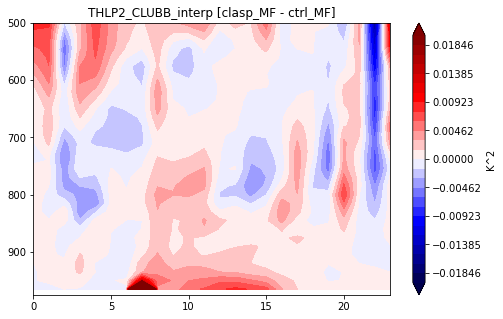

In [21]:
fig,axs = plt.subplots(1,1, figsize=(8,5) )

varSel     = 'THLP2_CLUBB_interp'
varNameSel = 'THLP2_CLUBB'
maxLev     = 500
cLevs      = np.arange(-0.02, 0.02+(0.04/26), 0.04/26)

cplt = axs.contourf(hourlyMeanSCAM.hour.values, hourlyMeanSCAM.levInterp.values, 
             np.squeeze(hourlyMeanSCAM.sel(case='clasp_MF')[varSel].values - 
                        hourlyMeanSCAM.sel(case='ctrl_MF')[varSel].values).transpose(),
             cLevs, cmap='seismic', extend='both',)
axs.invert_yaxis()
axs.set_ylim([975, maxLev])
axs.set_title(varSel+' [clasp_MF - ctrl_MF]')
fig.colorbar(cplt, label=namesDS[varNameSel].units)



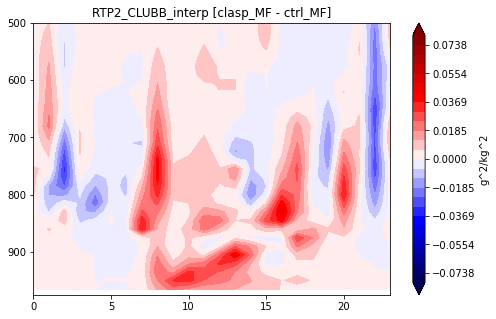

In [22]:
fig,axs = plt.subplots(1,1, figsize=(8,5) )

varSel     = 'RTP2_CLUBB_interp'
varNameSel = 'RTP2_CLUBB'
maxLev     = 500
cLevs      = np.arange(-0.08, 0.08+(0.16/26), 0.16/26)

cplt = axs.contourf(hourlyMeanSCAM.hour.values, hourlyMeanSCAM.levInterp.values, 
             np.squeeze(hourlyMeanSCAM.sel(case='clasp_MF')[varSel].values - 
                        hourlyMeanSCAM.sel(case='ctrl_MF')[varSel].values).transpose(),
             cLevs, cmap='seismic', extend='both',)
axs.invert_yaxis()
axs.set_ylim([975, maxLev])
axs.set_title(varSel+' [clasp_MF - ctrl_MF]')
fig.colorbar(cplt, label=namesDS[varNameSel].units)



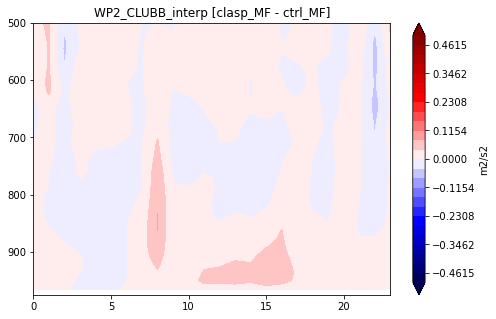

In [23]:
fig,axs = plt.subplots(1,1, figsize=(8,5) )

varSel     = 'WP2_CLUBB_interp'
varNameSel = 'WP2_CLUBB'
maxLev     = 500
cLevs      = np.arange(-0.5, 0.5+(1/26), 1/26)

cplt = axs.contourf(hourlyMeanSCAM.hour.values, hourlyMeanSCAM.levInterp.values, 
             np.squeeze(hourlyMeanSCAM.sel(case='clasp_MF')[varSel].values - 
                        hourlyMeanSCAM.sel(case='ctrl_MF')[varSel].values).transpose(),
             cLevs, cmap='seismic', extend='both',)
axs.invert_yaxis()
axs.set_ylim([975, maxLev])
axs.set_title(varSel+' [clasp_MF - ctrl_MF]')
fig.colorbar(cplt, label=namesDS[varNameSel].units)



## Look at a composite day? 

In [20]:
## Get days that are relatively dry?
dailyMeanSCAM  = scamDS.resample(time='1D').mean(dim='time')
dailyMeanSCAM  = dailyMeanSCAM.isel(time=np.arange(2,8))


In [89]:
dailyMeanSCAM.time

<xarray.DataArray 'time' (time: 6)>
array(['1997-06-20T00:00:00.000000000', '1997-06-21T00:00:00.000000000',
       '1997-06-22T00:00:00.000000000', '1997-06-23T00:00:00.000000000',
       '1997-06-24T00:00:00.000000000', '1997-06-25T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1997-06-20 1997-06-21 ... 1997-06-25

In [24]:
(dailyMeanSCAM.sel(case='ctrl_MF').PRECT.values*(3600*1000))

array([[[1.68483227e-02]],

       [[6.96070152e-04]],

       [[5.95700676e-05]],

       [[1.87233179e-01]],

       [[1.96212352e-01]],

       [[2.10953137e-01]]])

In [27]:
# Days with mean rain rates under this threshold will be considered 'dry' 
dryDayCutoff = 0.1

iDryDays = np.where( (dailyMeanSCAM.sel(case='ctrl_MF').PRECT.values*(3600*1000) )<=dryDayCutoff )[0] # Convert from m/s to mm/hr
dryDS    = dailyMeanSCAM.isel(time=iDryDays)

iWetDays = np.where( (dailyMeanSCAM.sel(case='ctrl_MF').PRECT.values*(3600*1000) )>dryDayCutoff )[0] # Convert from m/s to mm/hr
wetDS    = dailyMeanSCAM.isel(time=iWetDays)

inds_dryDays = []
for iDay in range(len(dryDS.time.values)):
    thisDayString = dryDS.date.sel(case='ctrl_MF').values[iDay].astype(str) 
    iSelDay       = np.where( (scamDS['time.year'].values  == int(thisDayString[0:4])) & 
                              (scamDS['time.month'].values == int(thisDayString[4:6])) & 
                              (scamDS['time.day'].values   == int(thisDayString[6:8])) )[0]
    inds_dryDays = np.append(inds_dryDays, iSelDay)
    

inds_wetDays = [] 
for iDay in range(len(wetDS.time.values)):
    thisDayString = wetDS.date.sel(case='ctrl_MF').values[iDay].astype(str) 
    iSelDay       = np.where( (scamDS['time.year'].values  == int(thisDayString[0:4])) & 
                              (scamDS['time.month'].values == int(thisDayString[4:6])) & 
                              (scamDS['time.day'].values   == int(thisDayString[6:8])) )[0]
    
    inds_wetDays = np.append(inds_wetDays, iSelDay)

scamDS_dryDays = scamDS.isel(time=inds_dryDays.astype(int))
scamDS_wetDays = scamDS.isel(time=inds_wetDays.astype(int))


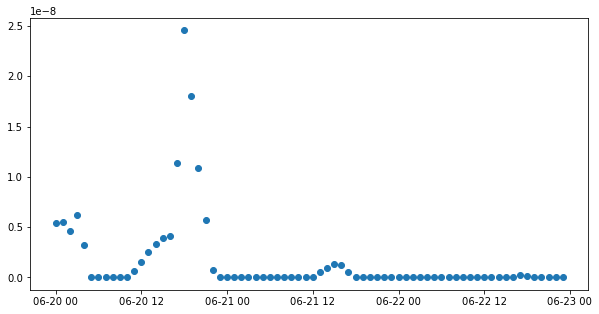

In [28]:
fig,axs = plt.subplots(1,1, figsize=(10,5) )
axs.plot(scamDS_dryDays.time.values, np.squeeze(scamDS_dryDays.sel(case='ctrl_MF').PRECT.values), 'o')


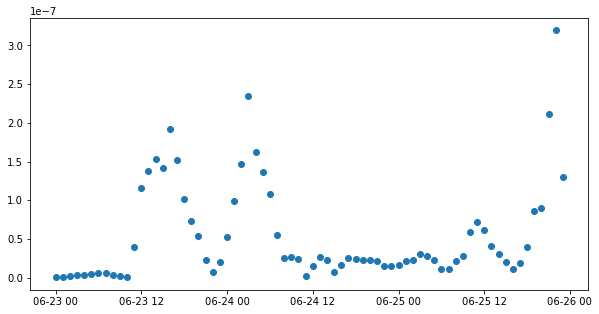

In [29]:
fig,axs = plt.subplots(1,1, figsize=(10,5) )
axs.plot(scamDS_wetDays.time.values, np.squeeze(scamDS_wetDays.sel(case='ctrl_MF').PRECT.values), 'o')


In [30]:
hrMean_dry = scamDS_dryDays.groupby('time.hour').mean(dim='time')
hrMean_wet = scamDS_wetDays.groupby('time.hour').mean(dim='time')


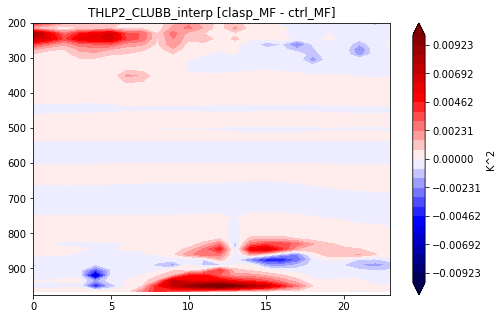

In [52]:
fig,axs = plt.subplots(1,1, figsize=(8,5) )

varSel     = 'THLP2_CLUBB_interp'
varNameSel = 'THLP2_CLUBB'
maxLev     = 200
cLevs      = np.arange(-0.01, 0.01+(0.02/26), 0.02/26)

cplt = axs.contourf(hrMean_dry.hour.values, hrMean_dry.levInterp.values, 
             np.squeeze(hrMean_dry.sel(case='clasp_MF')[varSel].values - 
                        hrMean_dry.sel(case='ctrl_MF')[varSel].values).transpose(),
             cLevs, cmap='seismic', extend='both',)
axs.invert_yaxis()
axs.set_ylim([975, maxLev])
axs.set_title(varSel+' [clasp_MF - ctrl_MF]')
fig.colorbar(cplt, label=namesDS[varNameSel].units)



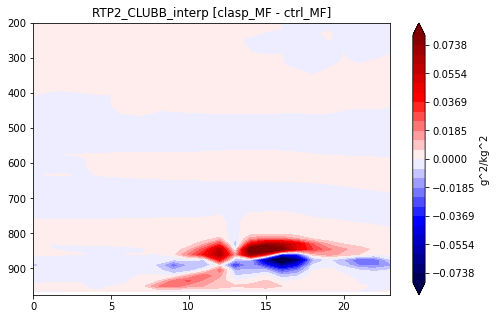

In [58]:
fig,axs = plt.subplots(1,1, figsize=(8,5) )

varSel     = 'RTP2_CLUBB_interp'
varNameSel = 'RTP2_CLUBB'
maxLev     = 200
cLevs      = np.arange(-0.08, 0.08+(0.16/26), 0.16/26)

cplt = axs.contourf(hrMean_dry.hour.values, hrMean_dry.levInterp.values, 
             np.squeeze(hrMean_dry.sel(case='clasp_MF')[varSel].values - 
                        hrMean_dry.sel(case='ctrl_MF')[varSel].values).transpose(),
             cLevs, cmap='seismic', extend='both',)
axs.invert_yaxis()
axs.set_ylim([975, maxLev])
axs.set_title(varSel+' [clasp_MF - ctrl_MF]')
fig.colorbar(cplt, label=namesDS[varNameSel].units)



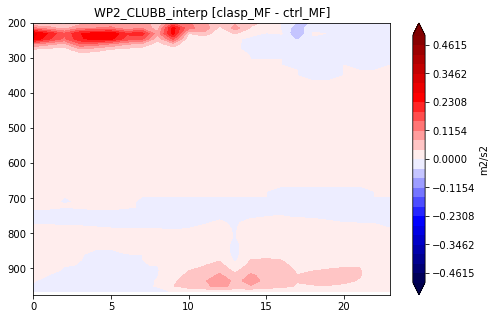

In [61]:
fig,axs = plt.subplots(1,1, figsize=(8,5) )

varSel     = 'WP2_CLUBB_interp'
varNameSel = 'WP2_CLUBB'
maxLev     = 200
cLevs      = np.arange(-0.5, 0.5+(1/26), 1/26)

cplt = axs.contourf(hrMean_dry.hour.values, hrMean_dry.levInterp.values, 
             np.squeeze(hrMean_dry.sel(case='clasp_MF')[varSel].values - 
                        hrMean_dry.sel(case='ctrl_MF')[varSel].values).transpose(),
             cLevs, cmap='seismic', extend='both',)
axs.invert_yaxis()
axs.set_ylim([975, maxLev])
axs.set_title(varSel+' [clasp_MF - ctrl_MF]')
fig.colorbar(cplt, label=namesDS[varNameSel].units)



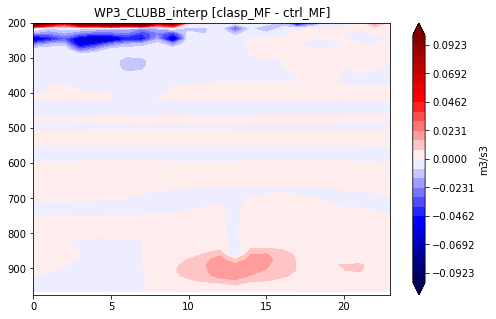

In [62]:
fig,axs = plt.subplots(1,1, figsize=(8,5) )

varSel     = 'WP3_CLUBB_interp'
varNameSel = 'WP3_CLUBB'
maxLev     = 200
cLevs      = np.arange(-0.1, 0.1+(0.2/26), 0.2/26)

cplt = axs.contourf(hrMean_dry.hour.values, hrMean_dry.levInterp.values, 
             np.squeeze(hrMean_dry.sel(case='clasp_MF')[varSel].values - 
                        hrMean_dry.sel(case='ctrl_MF')[varSel].values).transpose(),
             cLevs, cmap='seismic', extend='both',)
axs.invert_yaxis()
axs.set_ylim([975, maxLev])
axs.set_title(varSel+' [clasp_MF - ctrl_MF]')
fig.colorbar(cplt, label=namesDS[varNameSel].units)



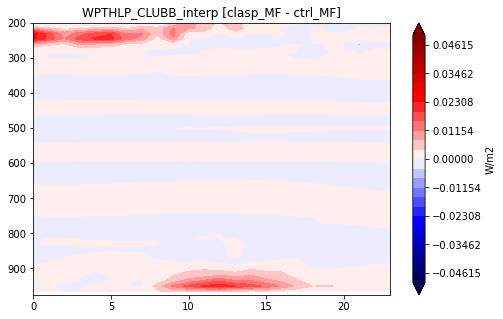

In [76]:
fig,axs = plt.subplots(1,1, figsize=(8,5) )

varSel     = 'WPTHLP_CLUBB_interp'
varNameSel = 'WPTHLP_CLUBB'
maxLev     = 200
cLevs      = np.arange(-0.05, 0.05+(0.1/26), 0.1/26)

cplt = axs.contourf(hrMean_dry.hour.values, hrMean_dry.levInterp.values, 
             np.squeeze(hrMean_dry.sel(case='clasp_MF')[varSel].values - 
                        hrMean_dry.sel(case='ctrl_MF')[varSel].values).transpose(),
             cLevs, cmap='seismic', extend='both',)
axs.invert_yaxis()
axs.set_ylim([975, maxLev])
axs.set_title(varSel+' [clasp_MF - ctrl_MF]')
fig.colorbar(cplt, label=namesDS[varNameSel].units)



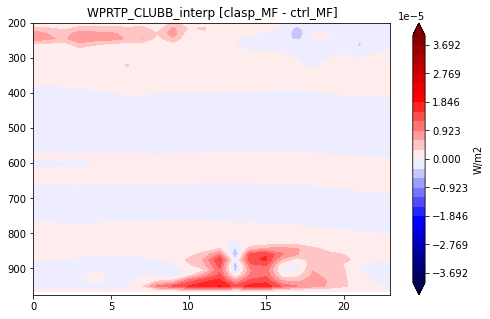

In [85]:
fig,axs = plt.subplots(1,1, figsize=(8,5) )

varSel     = 'WPRTP_CLUBB_interp'
varNameSel = 'WPRTP_CLUBB'
maxLev     = 200
cLevs      = np.arange(-0.00004, 0.00004+((2*0.00004)/26), (2*0.00004)/26)

cplt = axs.contourf(hrMean_dry.hour.values, hrMean_dry.levInterp.values, 
             np.squeeze(hrMean_dry.sel(case='clasp_MF')[varSel].values - 
                        hrMean_dry.sel(case='ctrl_MF')[varSel].values).transpose(),
             cLevs, cmap='seismic', extend='both',)
axs.invert_yaxis()
axs.set_ylim([975, maxLev])
axs.set_title(varSel+' [clasp_MF - ctrl_MF]')
fig.colorbar(cplt, label=namesDS[varNameSel].units)



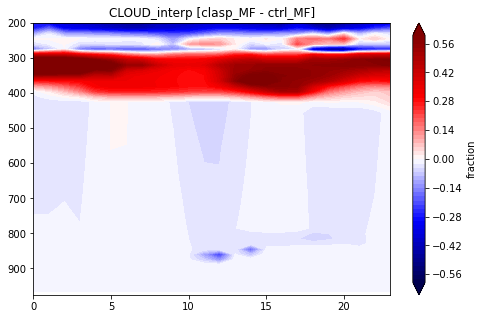

In [53]:
fig,axs = plt.subplots(1,1, figsize=(8,5) )

varSel     = 'CLOUD_interp'
varNameSel = 'CLOUD'
maxLev     = 200
cLevs      = np.arange(-0.6, 0.62, 0.02)

cplt = axs.contourf(hrMean_dry.hour.values, hrMean_dry.levInterp.values, 
             np.squeeze(hrMean_dry.sel(case='clasp_MF')[varSel].values - 
                        hrMean_dry.sel(case='ctrl_MF')[varSel].values).transpose(),
             cLevs, cmap='seismic', extend='both',)
axs.invert_yaxis()
axs.set_ylim([975, maxLev])
axs.set_title(varSel+' [clasp_MF - ctrl_MF]')
fig.colorbar(cplt, label=namesDS[varNameSel].units)



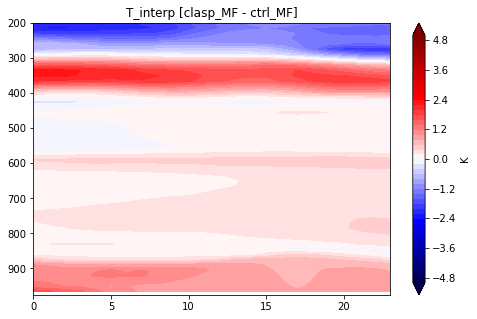

In [64]:
fig,axs = plt.subplots(1,1, figsize=(8,5) )

varSel     = 'T_interp'
varNameSel = 'T'
maxLev     = 200
cLevs      = np.arange(-5, 5.2, 0.2)

cplt = axs.contourf(hrMean_dry.hour.values, hrMean_dry.levInterp.values, 
             np.squeeze(hrMean_dry.sel(case='clasp_MF')[varSel].values - 
                        hrMean_dry.sel(case='ctrl_MF')[varSel].values).transpose(),
             cLevs, cmap='seismic', extend='both',)
axs.invert_yaxis()
axs.set_ylim([975, maxLev])
axs.set_title(varSel+' [clasp_MF - ctrl_MF]')
fig.colorbar(cplt, label=namesDS[varNameSel].units)



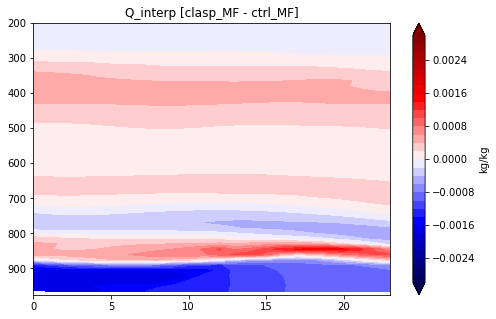

In [69]:
fig,axs = plt.subplots(1,1, figsize=(8,5) )

varSel     = 'Q_interp'
varNameSel = 'Q'
maxLev     = 200
cLevs      = np.arange(-3e-3, 3.2e-3, 0.2e-3)

cplt = axs.contourf(hrMean_dry.hour.values, hrMean_dry.levInterp.values, 
             np.squeeze(hrMean_dry.sel(case='clasp_MF')[varSel].values - 
                        hrMean_dry.sel(case='ctrl_MF')[varSel].values).transpose(),
             cLevs, cmap='seismic', extend='both',)
axs.invert_yaxis()
axs.set_ylim([975, maxLev])
axs.set_title(varSel+' [clasp_MF - ctrl_MF]')
fig.colorbar(cplt, label=namesDS[varNameSel].units)



## Confirm LASSO IOPs match?

Confirm that the IOPs work the same/match? This comparison right now is going to be tough, because using very different versions of CAM... and in Finley's I have fixed surface fluxes/Tg. Maybe the cleanest comparison is to run Finley's IOP through my past set up...?

In [176]:
newDir    = '/glade/u/home/mdfowler/temp/'
origDir   = '/glade/campaign/cgd/tss/mdfowler/CLASP_SCAMoutput/'

finleyIOP = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataFALSE_setSfcFlx.LASSO_20170923'
origIOP   = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.getLESdays_HTG_2017_noMult_start0923.cam.h0.2017-09-23-18060.nc'



In [177]:
origDS = xr.open_mfdataset(origDir+origIOP, preprocess=preprocess_h0, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')

Beginning interpolation...
NOTE: output being resampled to hourly


In [178]:
listFilesNew = np.sort(glob.glob(newDir+finleyIOP+'/atm/hist/'+finleyIOP+'*cam.h0*'))

newDS = xr.open_mfdataset(listFilesNew, preprocess=preprocess_h0, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')


Beginning interpolation...
NOTE: output being resampled to hourly


Text(0.5, 1.0, 'LHFLX')

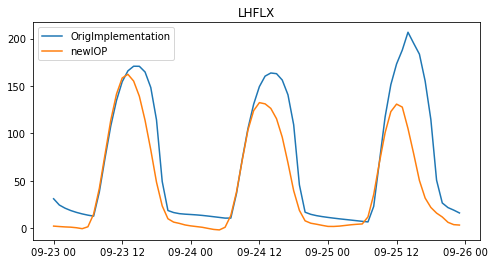

In [181]:
fig,axs = plt.subplots(1,1, figsize=(8,4))

varName = 'LHFLX'

axs.plot(origDS.time.values, np.squeeze(origDS[varName].values), label='OrigImplementation')
axs.plot(newDS.time.values, np.squeeze(newDS[varName].values), label='newIOP')
axs.legend()
axs.set_title(varName)


#### Approach 2: Compare the forcing files directly, just to be safe


In [139]:
origFile='/glade/work/mdfowler/CLASP/clasp-htg.bdate.nc'
newFile = '/glade/work/fhaychap/SGPvar_iops/2017/LASSO_2017_4scam.nc'

origDS = xr.open_dataset(origFile, decode_times=True)
newDS  = xr.open_dataset(newFile, decode_times=True)

iSelYear = np.where(origDS['time.year'].values==2017)[0]
origDS = origDS.isel(time=iSelYear)


In [146]:
selMon = 7
selDay = 5

iDay_orig = np.where( (origDS['time.month'].values==selMon) & 
                      (origDS['time.day'].values==selDay) )[0]
origDS_day = origDS.isel(time=iDay_orig)


iDay_new = np.where( (newDS['time.month'].values==selMon) & 
                     (newDS['time.day'].values==selDay) )[0]
newDS_day = newDS.isel(time=iDay_new)


Text(0.5, 1.0, 'Old IOP file: q_adv_h [kg/kg/s]')

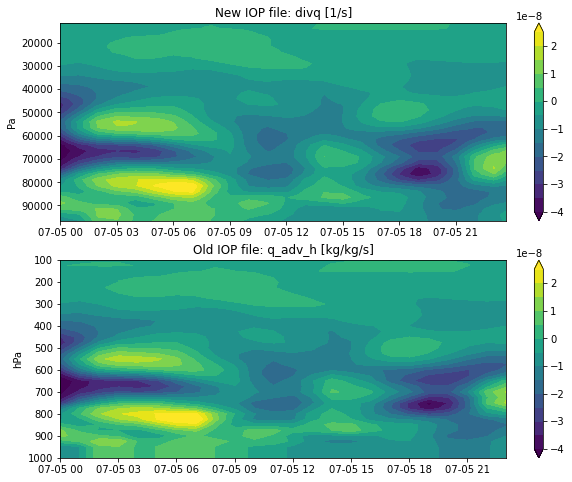

In [170]:
fig,axs = plt.subplots(2,1, figsize=(10,8))
axs = axs.ravel()

c1 = axs[0].contourf(newDS_day.time.values, newDS_day.lev.values, 
         np.squeeze(newDS_day.divq.values).transpose(), 
         np.arange(-4e-8, 3e-8, 0.5e-8),
         extend='both')
axs[0].set_ylabel('Pa')
axs[0].invert_yaxis()
cbar = fig.colorbar(c1, ax=axs[0])


c2 = axs[1].contourf(origDS_day.time.values, origDS_day.lev.values, 
         np.squeeze(origDS_day.q_adv_h.values*1e-3*(1/3600)).transpose(), 
         np.arange(-4e-8, 3e-8, 0.5e-8),
         extend='both')
axs[1].set_ylabel('hPa')
axs[1].invert_yaxis()
cbar = fig.colorbar(c2, ax=axs[1])

axs[0].set_title('New IOP file: divq [1/s]')
axs[1].set_title('Old IOP file: q_adv_h [kg/kg/s]')

         

Text(0.5, 1.0, 'Old IOP file: T_adv_h [K/s]')

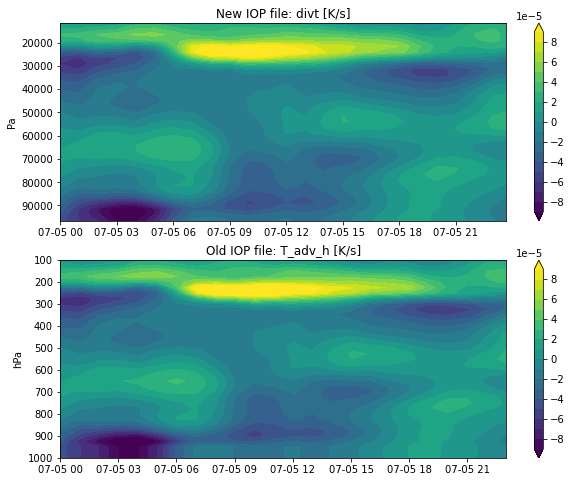

In [174]:
fig,axs = plt.subplots(2,1, figsize=(10,8))
axs = axs.ravel()

c1 = axs[0].contourf(newDS_day.time.values, newDS_day.lev.values, 
         np.squeeze(newDS_day.divT.values).transpose(), 
         np.arange(-9e-5, 10e-5, 1e-5),
         extend='both')
axs[0].set_ylabel('Pa')
axs[0].invert_yaxis()
cbar = fig.colorbar(c1, ax=axs[0])


c2 = axs[1].contourf(origDS_day.time.values, origDS_day.lev.values, 
         np.squeeze(origDS_day.T_adv_h.values*(1/3600)).transpose(), 
         np.arange(-9e-5, 10e-5, 1e-5),
         extend='both')
axs[1].set_ylabel('hPa')
axs[1].invert_yaxis()
cbar = fig.colorbar(c2, ax=axs[1])

axs[0].set_title('New IOP file: divt [K/s]')
axs[1].set_title('Old IOP file: T_adv_h [K/s]')

         